In [ ]:
from fastspeech.modules import FastSpeech, FFTConfig, DPConfig
from fastspeech.data import *
from fastspeech.training import *
from fastspeech.visualize import *
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn.functional as F
from functools import partial
from pathlib import Path
import json
import torch

In [ ]:
path = Path("../../data/LJSpeech-1.1/")
path_vocab = Path("../../data/CMUDict/cmudict-0.7b.symbols.txt")
path_stats = Path("../sample_data/lj_mel_stats.json")

In [ ]:
with open(path_stats, 'r') as f: stats = json.load(f)

In [ ]:
stats = {key: float(stats[key]) for key in stats}
stats["top_db"] = 35
stats

{'min': -0.000100009995,
 'max': 12.625555,
 'mean': 0.0021890362,
 'std': 0.02285596,
 'top_db': 35}

In [ ]:
ds = TTSDataset(path, path_vocab, ds=slice(int(13084*0.01)), preload=True, stats=stats)

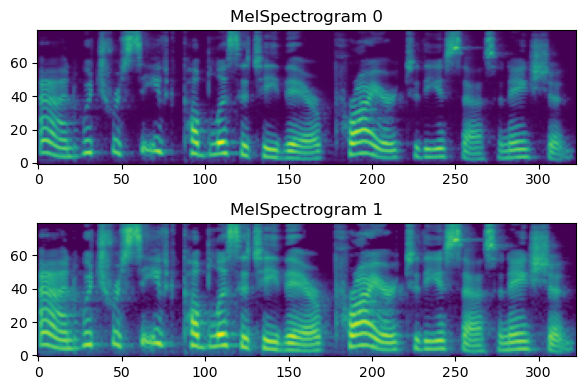

In [ ]:
normalized = ds.mels[0]
denormalized = ds.norm.denormalize(normalized)
show_mels([normalized, denormalized])

In [ ]:
bs = 64
n_workers = 0
pres_worker = False

collate_fn_p = partial(collate_fn, pad_num=ds.vocab.pad_num, norm=ds.norm)
dl = DataLoader(ds, bs, shuffle=True, num_workers=n_workers, pin_memory=True,
                collate_fn=collate_fn_p, persistent_workers=pres_worker, drop_last=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
di = iter(dl)

In [ ]:
next(di)[1].sum(-1)

AssertionError: 

In [ ]:
log_interval = 5
ni = 384
config = {
    "model": {
        "ne": len(ds.vocab.vocab), "ni": ni, "no": 80, 
        "ec": FFTConfig(ni=ni, nh=2, fs=1536, ks=[3,3], p=[0.1,0.1]), "enb": 6, 
        "dc": FFTConfig(ni=ni, nh=2, fs=1536, ks=[3,3], p=[0.1,0.1]), "dnb": 6, 
        "dpc": DPConfig(ni=ni, fs=256, ks=[3,3], p=[0.1,0.1]),
        "device": device
    },
    "optim": {"lr":  1e-4, "betas": (0.9, 0.98), "eps": 1e-10, "weight_decay": 0},
    "scheduler": {"lr_mul": 1., "d_model": ni, "n_warmup_steps": 4000},
}

learner = FastspeechLearner(dl, ds.norm, FastSpeech, Adam, TransformerScheduler, 
                            config, mae_loss, F.mse_loss, fp_16=True, device=device,
                            log_interval=log_interval)

In [ ]:
learner.fit(10)